In [1]:
%matplotlib inline

from matplotlib.pyplot import subplots, savefig
import richardsplot as rplot

from utilities.analysis import plotting
from utilities.ccd import CCD
from utilities.containers import *
from utilities.conversions import magToFlux

ModuleNotFoundError: No module named 'analysis'

In [2]:
cmap = rplot.palettable.colorbrewer.diverging.PuOr_11.mpl_colormap

In [9]:
!pwd
!mkdir plots/c08/

/home/jackeline/Research/k2_pipeline/CARMA
mkdir: cannot create directory ‘plots/c08/’: File exists


In [3]:
pixmapfile = "/media/jackeline/UUI/PixelMaps/K2_target_pixels.hdf5"

#  Make CCD using PixelMapContainer and PixelMapGenerator

In [4]:
ccd = CCD(module=10, channel=1, field='FLUX', campaign=8)
cont = PixelMapContainer.from_hdf5(pixmapfile, ccd)
cont.save(pixmapfile)
                        
gen = PixMapGenerator(cont)
print "Finished Making", ccd
            

  Writing... (Do Not Turn off Device or Stop Kernel)

Finished Making CCD(module=10, channel=1, field='FLUX', campaign=8)


Plotting first lc in container 

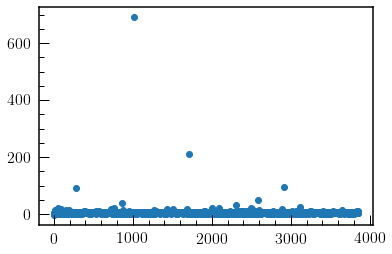

In [7]:
import matplotlib 
import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(xrange(np.shape(gen.containers.containers[0].pixels)[0]),gen.containers.containers[0].pixels[:,1,1])

# tracking pixels

In [124]:
'''
pixellc.py

functions for generating custom representations of K2 "Pixel Light Curves"
from PixMapGenerators to be sent to functions for plotting or further analysis
'''

from itertools import izip, imap, ifilter
import numpy as np


def New_get_pixel_lc(gen, percentiles, flux_range=None, mag_range=None,static = False, stat_funcs=None):
    if flux_range is not None:
        lower, higher = sorted(flux_range)

    if stat_funcs is None:
        stat_funcs = (np.median,)

    ccd = gen.ccd
    N = gen.N
    M = len(percentiles)-1
    L = len(stat_funcs)

    #lc = np.empty((N, M, L+2))
    lc = np.empty((N,M,5)) # min, max, var, median, mean
    lc[::] = np.nan
    #lc[::] = np.nan


    l_bin_edges = np.empty((gen.N, len(percentiles)))
    def _get_epochs():

        if flux_range is not None:
            return _get_filtered_epochs()

        return _get_full_epochs()

    def _get_full_epochs():

        for i, g in enumerate(imap(gen.get_unordered, xrange(gen.N))):

                yield g

    def _get_filtered_epochs():

        for i, g in enumerate(imap(gen.get_unordered, xrange(gen.N))):

            mask = (g > lower) & (g < higher)
            yield g[mask]

    epochs = list(_get_epochs())

    '''percentiles is a flat array of percentiles ranging from 0 to 100'''
    N = gen.N
    higher, lower = None, None
    if mag_range is None:
        higher, lower = np.inf, -np.inf
        mag_range = (lower, higher)
    else:
        higher, lower = magToFlux(np.array(sorted(mag_range)))
    if np.inf in mag_range:
        lower = -np.inf
        
        
    pixel_median_flux = []
    allpixel = []
    source_pix_mask = np.array([])
    for i in range(len(gen.containers.containers[:])):
        pix_t_index = np.shape(gen.containers.containers[i].pixels)[0]
        pix_row = np.shape(gen.containers.containers[i].pixels)[1]
        pix_column = np.shape(gen.containers.containers[i].pixels)[2]
        for r in range (pix_row):
            for c in range (pix_column):
                fluxes = gen.containers.containers[i].pixels[:,r,c]
                #stack all pixels all at epoch = l index 
                allpixel.append(fluxes)
                #mask = (fluxes > lower) & (fluxes < higher)
                pixel_median_flux.append(np.nanmedian(fluxes))
        
        max_flux = np.nanpercentile((np.array(pixel_median_flux)[(len(pixel_median_flux)-(pix_row * pix_column)):len(pixel_median_flux)] ),95)

        subset = (np.array(pixel_median_flux)[(len(pixel_median_flux)-(pix_row * pix_column)):len(pixel_median_flux)])
        smask = np.where(subset <= max_flux)[0]
        #mask bright pixels
        #smask = np.where(subset >= max_flux)[0]


        smask = (len(pixel_median_flux)-(pix_row * pix_column))+smask[:]

        source_pix_mask = np.append(source_pix_mask,smask)

            
    print("computed median fluxes for %d pixels" %len(pixel_median_flux)) 
    
    #remove neg flux pixels and nans
  
    pixel_median_flux = np.delete(pixel_median_flux,source_pix_mask)
    keep = np.where(np.isnan(np.array(pixel_median_flux)[:])==False)[0] 
    print('Removing %d pixels due to negative flux or NANs' %(len(pixel_median_flux)-len(keep)))
    
    #assign pixel a percentile based on median
    percentile_bin_edges = np.nanpercentile(np.array(pixel_median_flux)[keep], percentiles, axis=0).T
    percentile_bin_edges[-1]  += 1e-10  
    indices = np.digitize(np.array(pixel_median_flux), percentile_bin_edges)-1 
    print("NUmber of pixels in percentile%d"%len(np.array(pixel_median_flux)[keep]))
    
    

    for i,g in enumerate((gen.get_unordered(i) for i in xrange(N))):
        #max_flux = np.nanpercentile((np.array(pixel_median_flux[keep])[(len(pixel_median_flux)-(pix_row * pix_column)):len(pixel_median_flux)] ),5)

        #print('before %d'%len(g))
        g = np.delete(g,source_pix_mask.astype('int'))
        #print('after %d'%len(g))
        m = (g > lower) & (g < higher)
        
        if m.any():
            pixels_g = g[m]

            #********Pixel Position and Median FLux Dependence*****
            if static == True:
                g_index = indices[m]
            else:
            #********Flux Dependence*****
                percentile_bin_edges = np.percentile(g[m], percentiles)
                g_index = np.digitize(pixels_g, percentile_bin_edges)-1
                
            unique_indices = np.unique(g_index)
            #print("number of percentile bins in this cadence %d" %len(unique_indices))
            for j, bin_num in enumerate(unique_indices[unique_indices<500]):
                cut = pixels_g[g_index == bin_num]
                if len(cut)>0:
                    lc[i,j,2] = np.var(cut)
                    lc[i,j,3] = np.median(cut)


    return lc


In [74]:
percentiles = np.linspace(0, 100, 501)
flux_range = map(magToFlux,(50,1))
lc = New_get_pixel_lc(gen,percentiles, flux_range = flux_range)


/home/jackeline/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


computed median fluxes for 23530 pixels
Removing 514 pixels due to negative flux or NANs
NUmber of pixels in percentile23016


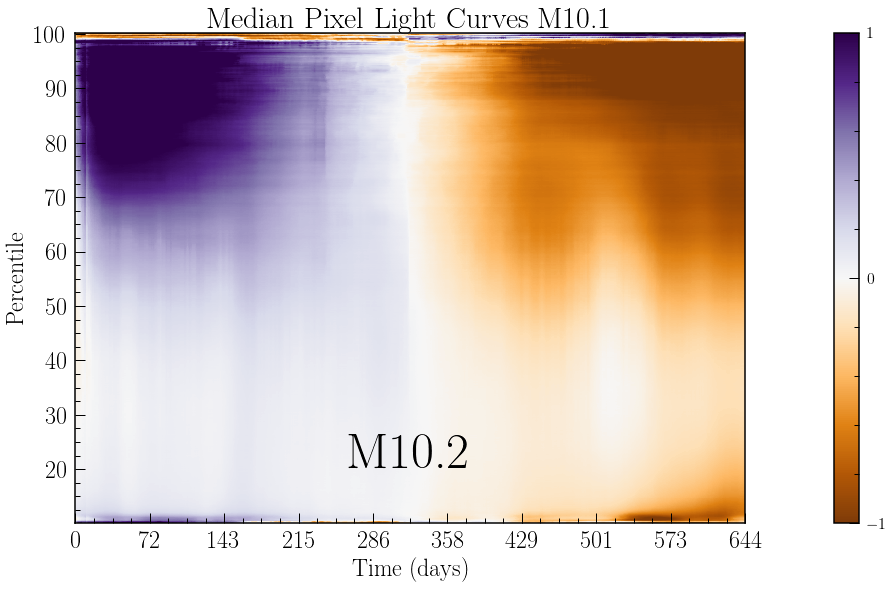

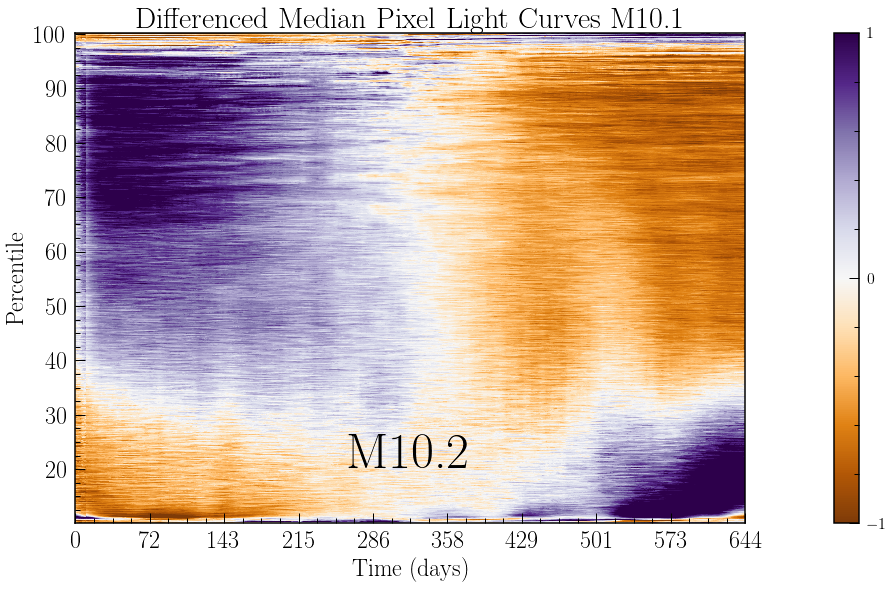

In [75]:
fig, ax = subplots(1,1, figsize=(16,9))
im = plotting.plot_pixel_lc(ax, lc[:,:,3], smooth=120, image=True,
                          aspect='auto', cmap=cmap, vmin=-1, vmax=1)
plotting.format_pixel_image(ax, im, lc.shape[0])
ax.set_title("Median Pixel Light Curves M{}.{}".format(ccd.module, ccd.channel),
                fontsize=30)
ax.plot(0, 0, "-", label="M{}.{}".format(ccd.module, ccd.channel+1))    
ax.legend(fontsize = 50, frameon=False, loc = 8, handlelength=0, handletextpad=0,)
savefig('plots/c{:02d}/Module{}Channel{}PixelMapFull.png'.format(ccd.campaign, ccd.module, ccd.channel))
    
    #Make the differenced image map
fig, ax = subplots(1,1, figsize=(16,9))
im = plotting.plot_pixel_lc(ax, lc[:,:,3], smooth=120, image=True,
                          differenced=True, aspect='auto', cmap=cmap, vmin=-1, vmax=1)
plotting.format_pixel_image(ax, im, lc.shape[0])
ax.set_title("Differenced Median Pixel Light Curves M{}.{}".format(ccd.module, ccd.channel),
                fontsize=30)
ax.plot(0, 0, "-", label="M{}.{}".format(ccd.module, ccd.channel+1))    
ax.legend(fontsize = 50, frameon=False, loc = 8, handlelength=0, handletextpad=0,)
savefig('plots/c{:02d}/Module{}Channel{}PixelMapDiff.png'.format(ccd.campaign, ccd.module, ccd.channel))
    

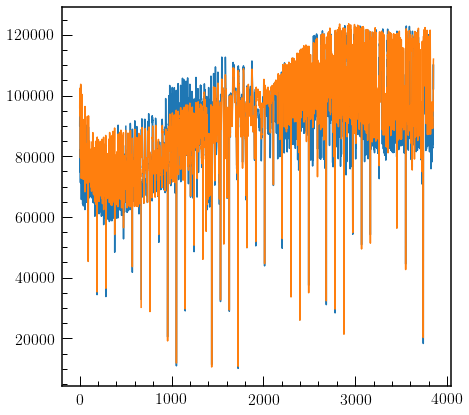

In [79]:
import matplotlib.pyplot as plt
plt.plot(xrange(len(lc2[:,-1,3])),lc2[:,-1,3]-lc2[:,-2,3])

plt.plot(xrange(len(lc[:,-1,3])),lc[:,-1,3]-lc[:,-2,3])
#plt.plot(xrange(len(lc[:,-1,3])),lc[:,-2,3]-lc[:,-3,3])


# Removed source pixels

In [60]:
lc2 = New_get_pixel_lc(gen,percentiles, flux_range = flux_range)


/home/jackeline/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


computed median fluxes for 23530 pixels
Removing 514 pixels due to negative flux or NANs
NUmber of pixels in percentile21779
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805


/home/jackeline/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:96: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/home/jackeline/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:112: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805


before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805


before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 0
after 0
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 2

before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805


before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805


before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805


before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805


before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805


before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805


before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805


before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805


before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805


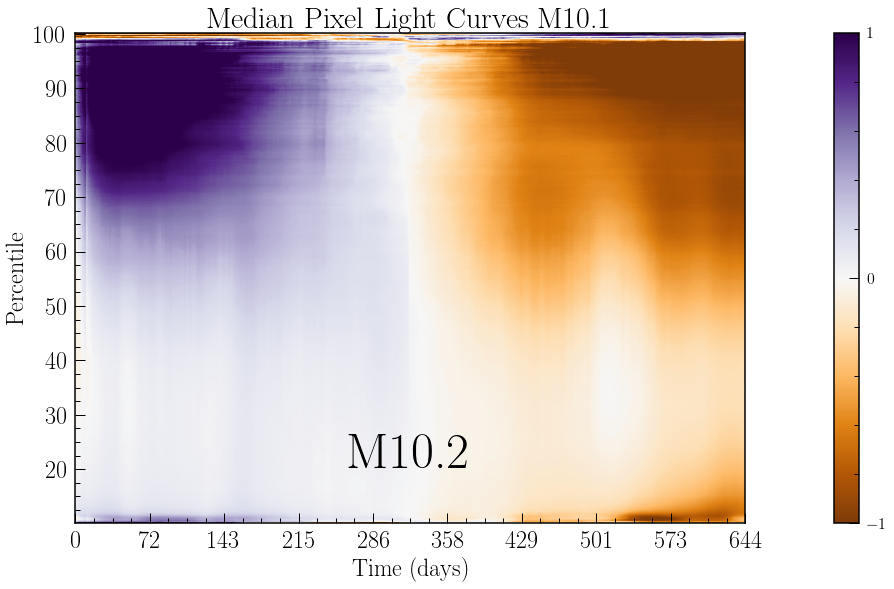

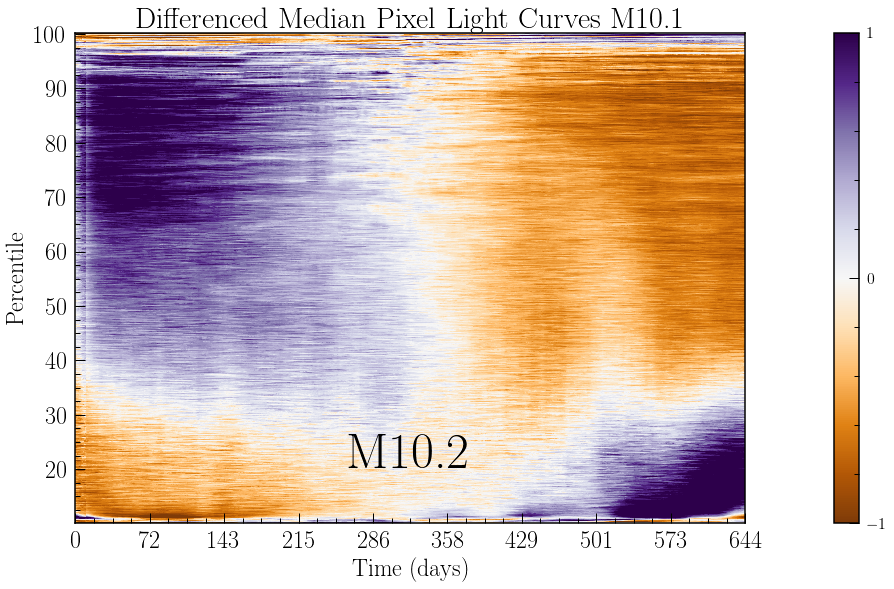

In [70]:
fig, ax = subplots(1,1, figsize=(16,9))
im = plotting.plot_pixel_lc(ax, lc2[:,:,3], smooth=120, image=True,
                          aspect='auto', cmap=cmap, vmin=-1, vmax=1)
plotting.format_pixel_image(ax, im, lc2.shape[0])
ax.set_title("Median Pixel Light Curves M{}.{}".format(ccd.module, ccd.channel),
                fontsize=30)
ax.plot(0, 0, "-", label="M{}.{}".format(ccd.module, ccd.channel+1))    
ax.legend(fontsize = 50, frameon=False, loc = 8, handlelength=0, handletextpad=0,)
savefig('plots/c{:02d}/Module{}Channel{}PixelMapFull_sourcepix.png'.format(ccd.campaign, ccd.module, ccd.channel))
    
    #Make the differenced image map
fig, ax = subplots(1,1, figsize=(16,9))
im = plotting.plot_pixel_lc(ax, lc2[:,:,3], smooth=120, image=True,
                          differenced=True, aspect='auto', cmap=cmap, vmin=-1, vmax=1)
plotting.format_pixel_image(ax, im, lc2.shape[0])
ax.set_title("Differenced Median Pixel Light Curves M{}.{}".format(ccd.module, ccd.channel),
                fontsize=30)
ax.plot(0, 0, "-", label="M{}.{}".format(ccd.module, ccd.channel+1))    
ax.legend(fontsize = 50, frameon=False, loc = 8, handlelength=0, handletextpad=0,)
savefig('plots/c{:02d}/Module{}Channel{}PixelMapDiff.png'.format(ccd.campaign, ccd.module, ccd.channel))
    

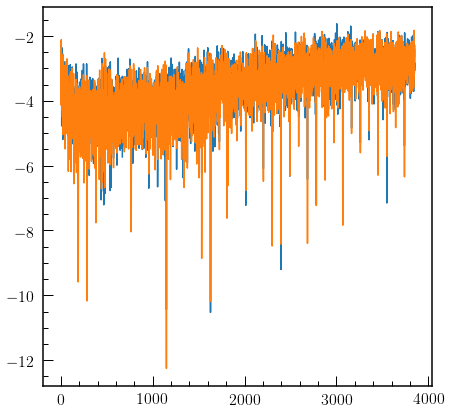

In [82]:
plt.plot(xrange(len(lc2[:,-1,3])),lc2[:,-100,3]-lc2[:,-99,3])
plt.plot(xrange(len(lc2[:,-1,3])),lc[:,-100,3]-lc[:,-99,3])


In [125]:
lc5 = New_get_pixel_lc(gen,percentiles, flux_range = flux_range)


/home/jackeline/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in less_equal


computed median fluxes for 23530 pixels
Removing 514 pixels due to negative flux or NANs
NUmber of pixels in percentile1236


/home/jackeline/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:97: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/home/jackeline/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:113: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


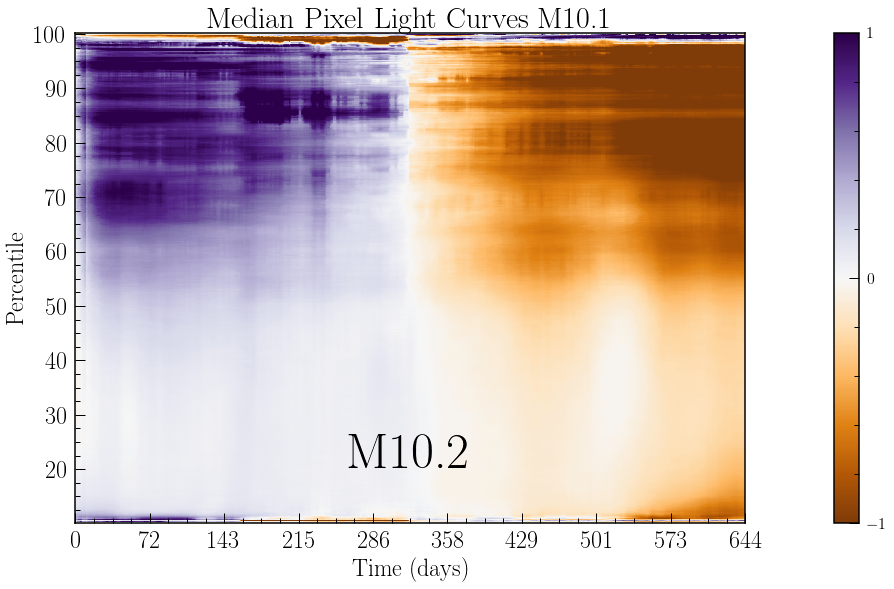

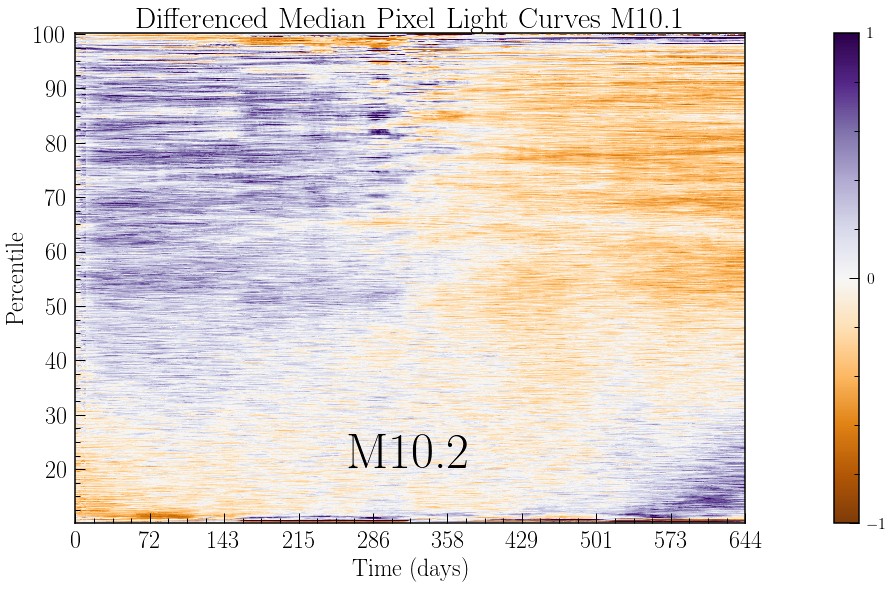

In [126]:
fig, ax = subplots(1,1, figsize=(16,9))
im = plotting.plot_pixel_lc(ax, lc5[:,:,3], smooth=120, image=True,
                          aspect='auto', cmap=cmap, vmin=-1, vmax=1)
plotting.format_pixel_image(ax, im, lc5.shape[0])
ax.set_title("Median Pixel Light Curves M{}.{}".format(ccd.module, ccd.channel),
                fontsize=30)
ax.plot(0, 0, "-", label="M{}.{}".format(ccd.module, ccd.channel+1))    
ax.legend(fontsize = 50, frameon=False, loc = 8, handlelength=0, handletextpad=0,)
savefig('plots/c{:02d}/Module{}Channel{}PixelMapFull_targets_95.png'.format(ccd.campaign, ccd.module, ccd.channel))
    
    #Make the differenced image map
fig, ax = subplots(1,1, figsize=(16,9))
im = plotting.plot_pixel_lc(ax, lc5[:,:,3], smooth=120, image=True,
                          differenced=True, aspect='auto', cmap=cmap, vmin=-1, vmax=1)
plotting.format_pixel_image(ax, im, lc5.shape[0])
ax.set_title("Differenced Median Pixel Light Curves M{}.{}".format(ccd.module, ccd.channel),
                fontsize=30)
ax.plot(0, 0, "-", label="M{}.{}".format(ccd.module, ccd.channel+1))    
ax.legend(fontsize = 50, frameon=False, loc = 8, handlelength=0, handletextpad=0,)
savefig('plots/c{:02d}/Module{}Channel{}PixelMapDiff_targets_95.png'.format(ccd.campaign, ccd.module, ccd.channel))
    

In [68]:
lc_static = New_get_pixel_lc(gen,percentiles, flux_range = flux_range, static = True)


/home/jackeline/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


computed median fluxes for 23530 pixels
Removing 514 pixels due to negative flux or NANs
NUmber of pixels in percentile21779
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805


/home/jackeline/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:96: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/home/jackeline/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:112: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
/home/jackeline/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:121: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 22293 but corresponding boolean dimension is 21805


before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805


before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805


before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805


before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805


before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805


before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805


before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805


before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805


before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805


before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805


before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805


before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805
before 23016
after 21805


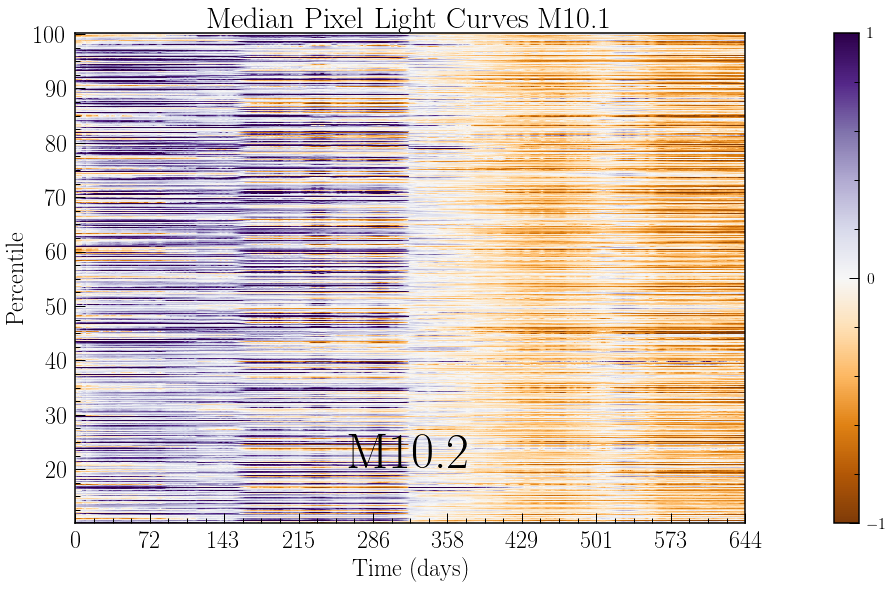

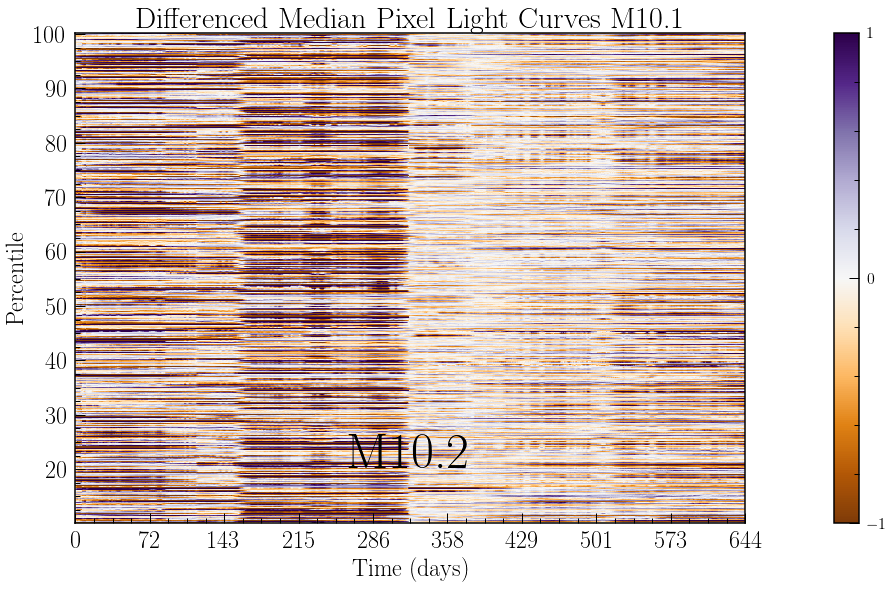

In [69]:
fig, ax = subplots(1,1, figsize=(16,9))
im = plotting.plot_pixel_lc(ax, lc_static[:,:,3], smooth=120, image=True,
                          aspect='auto', cmap=cmap, vmin=-1, vmax=1)
plotting.format_pixel_image(ax, im, lc_static.shape[0])
ax.set_title("Median Pixel Light Curves M{}.{}".format(ccd.module, ccd.channel),
                fontsize=30)
ax.plot(0, 0, "-", label="M{}.{}".format(ccd.module, ccd.channel+1))    
ax.legend(fontsize = 50, frameon=False, loc = 8, handlelength=0, handletextpad=0,)
savefig('plots/c{:02d}/Module{}Channel{}PixelMapFullklklklkjkllkkj.png'.format(ccd.campaign, ccd.module, ccd.channel))
    
    #Make the differenced image map
fig, ax = subplots(1,1, figsize=(16,9))
im = plotting.plot_pixel_lc(ax, lc_static[:,:,3], smooth=120, image=True,
                          differenced=True, aspect='auto', cmap=cmap, vmin=-1, vmax=1)
plotting.format_pixel_image(ax, im, lc_static.shape[0])
ax.set_title("Differenced Median Pixel Light Curves M{}.{}".format(ccd.module, ccd.channel),
                fontsize=30)
ax.plot(0, 0, "-", label="M{}.{}".format(ccd.module, ccd.channel+1))    
ax.legend(fontsize = 50, frameon=False, loc = 8, handlelength=0, handletextpad=0,)
savefig('plots/c{:02d}/Module{}Channel{}PixelMapDiff.png'.format(ccd.campaign, ccd.module, ccd.channel))

# rows and columns

In [12]:
'''
pixellc.py

functions for generating custom representations of K2 "Pixel Light Curves"
from PixMapGenerators to be sent to functions for plotting or further analysis
'''

from itertools import izip, imap, ifilter
import numpy as np


def get_pixelrow_lc(gen, flux_range=None, mag_range=None, stat_funcs=None):
    if flux_range is not None:
        lower, higher = sorted(flux_range)

    if stat_funcs is None:
        stat_funcs = (np.median,)

    ccd = gen.ccd
    N = gen.N

    def _get_epochs():

        if flux_range is not None:
            return _get_filtered_epochs()

        return _get_full_epochs()

    def _get_full_epochs():

        for i, g in enumerate(imap(gen.get_unordered, xrange(gen.N))):

                yield g

    def _get_filtered_epochs():

        for i, g in enumerate(imap(gen.get_unordered, xrange(gen.N))):

            mask = (g > lower) & (g < higher)
            yield g[mask]

    epochs = list(_get_epochs())

    '''percentiles is a flat array of percentiles ranging from 0 to 100'''
    N = gen.N
    higher, lower = None, None
    if mag_range is None:
        higher, lower = np.inf, -np.inf
        mag_range = (lower, higher)
    else:
        higher, lower = magToFlux(np.array(sorted(mag_range)))
    if np.inf in mag_range:
        lower = -np.inf
        
        
    pixel_median_flux = []
    allpixel = []
    rows_n = []
    columns_n = []
    for i in range(len(gen.containers.containers[:])):
        pix_t_index = np.shape(gen.containers.containers[i].pixels)[0]
        pix_row = np.shape(gen.containers.containers[i].pixels)[1]
        pix_column = np.shape(gen.containers.containers[i].pixels)[2]

        for r in range (pix_row):
            for c in range (pix_column):
                fluxes = gen.containers.containers[i].pixels[:,r,c]
                #stack all pixels all at epoch = l index 
                allpixel.append(fluxes)
                #mask = (fluxes > lower) & (fluxes < higher)
                pixel_median_flux.append([r,c,np.nanmedian(fluxes)])
                rows_n.append(gen.containers.containers[i].row)
                #columns_n.append(gen.containers.containers[i].col)
    print("computed median fluxes for %d pixels" %len(pixel_median_flux)) 
    
    #remove neg flux pixels and nans
    keep = np.where(np.isnan(np.array(pixel_median_flux)[:,2])==False)[0] 
    print('Removing %d pixels due to negative flux or NANs' %(len(pixel_median_flux)-len(keep)))
    
    
        
    rows_index = np.array(rows_n)[keep]
    print(len(((rows_index))))

    print(len((np.unique(rows_index))))
    #columns_index = np.array(pixel_median_flux)[keep,1]
    #print(len(columns_index))
    
    M = len((np.unique(rows_index)))
    print("M%d"%(M))
    #M = pix_column
    L = len(stat_funcs)

    #lc = np.empty((N, M, L+2))
    lc = np.empty((N,M,5)) # min, max, var, median, mean
    lc[::] = np.inf


    for i,g in enumerate((gen.get_unordered(i) for i in xrange(N))):
        
        m = (g > lower) & (g < higher)
        if m.any():
            pixels_g = g[m]

            
            #********Flux Dependence*****
            #percentile_bin_edges = np.percentile(g[m], percentiles)
            g_index = rows_index[m] 
            
            #********Pixel Position and Median FLux Dependence*****
            #g_index = indices[m]
            unique_indices = np.sort(np.unique(g_index))
            #print("number of percentile bins in this cadence %d" %len(unique_indices))
            for j, bin_num in enumerate(unique_indices):
                cut = pixels_g[g_index == bin_num]
                if len(cut)>0:
                    lc[i,j,2] = np.var(cut)
                    lc[i,j,3] = np.nanmedian(cut)


    return lc


In [13]:

flux_range = map(magToFlux,(50,1))
lc = get_pixelrow_lc(gen, flux_range = flux_range)


computed median fluxes for 23530 pixels
Removing 514 pixels due to negative flux or NANs
23016
243
M243


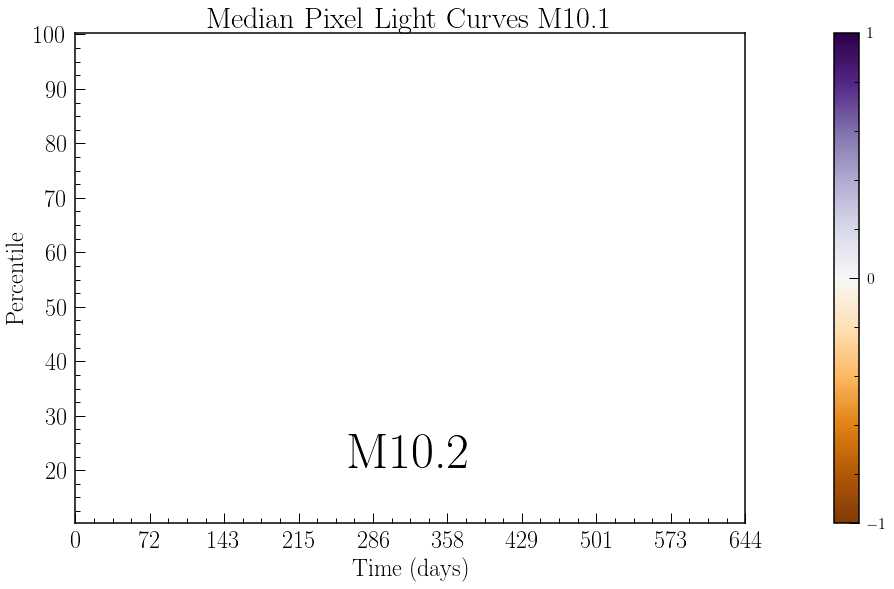

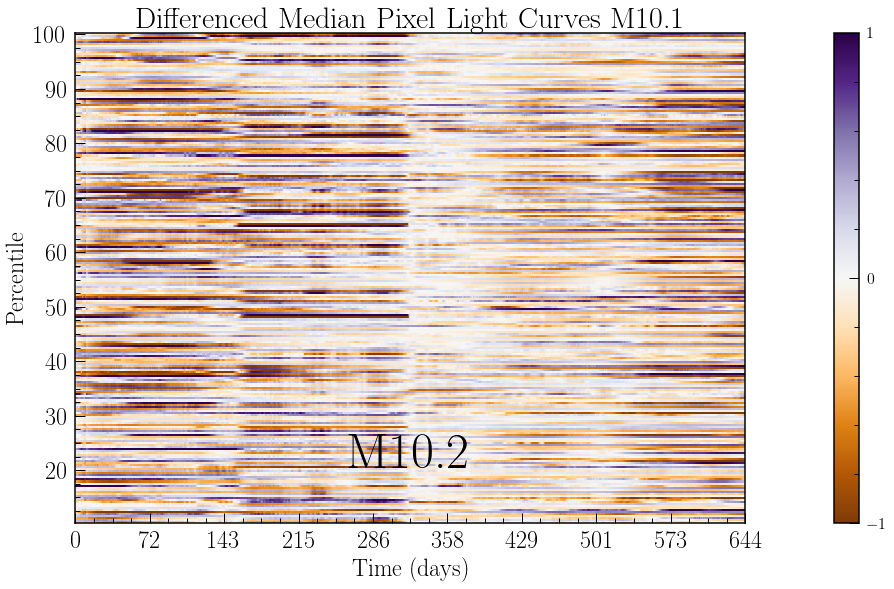

In [17]:

fig, ax = subplots(1,1, figsize=(16,9))
im = plotting.plot_pixel_lc(ax, lc[:,:,3], smooth=120, image=True,
                          aspect='auto', cmap=cmap, vmin=-1, vmax=1)
plotting.format_pixel_image(ax, im, lc.shape[0])
ax.set_title("Median Pixel Light Curves M{}.{}".format(ccd.module, ccd.channel),
                fontsize=30)
ax.plot(0, 0, "-", label="M{}.{}".format(ccd.module, ccd.channel+1))    
ax.legend(fontsize = 50, frameon=False, loc = 8, handlelength=0, handletextpad=0,)
savefig('plots/c{:02d}/Module{}Channel{}PixelMapFullklklklkjkllkkj.png'.format(ccd.campaign, ccd.module, ccd.channel))
    
    #Make the differenced image map
fig, ax = subplots(1,1, figsize=(16,9))
im = plotting.plot_pixel_lc(ax, lc[:,:,3], smooth=120, image=True,
                          differenced=True, aspect='auto', cmap=cmap, vmin=-1, vmax=1)
plotting.format_pixel_image(ax, im, lc.shape[0])
ax.set_title("Differenced Median Pixel Light Curves M{}.{}".format(ccd.module, ccd.channel),
                fontsize=30)
ax.plot(0, 0, "-", label="M{}.{}".format(ccd.module, ccd.channel+1))    
ax.legend(fontsize = 50, frameon=False, loc = 8, handlelength=0, handletextpad=0,)
savefig('plots/c{:02d}/Module{}Channel{}PixelMapDiff.png'.format(ccd.campaign, ccd.module, ccd.channel))

In [ ]:
gen.containers.containers[5].col
#gen.containers.containers[1].row


In [16]:
lc[0,:,3]

array([  1.42756386e+01,   1.40357914e+01,   1.28043289e+02,
         6.52845240e+00,   8.69746494e+00,   9.65896988e+00,
         6.82404470e+00,   1.09733200e+00,   1.08474703e+01,
         2.03829899e+01,   2.57944794e+01,   2.50193071e+00,
         3.85051084e+00,   6.81357193e+00,   3.59098282e+01,
         6.62617874e+01,   8.58309746e+00,   1.12986050e+01,
         1.00865424e+00,   1.06916618e+01,   1.27448330e+01,
         3.92162800e+00,   5.85507870e-01,   2.54404640e+01,
         4.66936989e+01,   9.25133896e+00,   3.94579315e+01,
         1.20735779e+01,   8.60933876e+00,   9.02413845e+00,
         4.82494116e+00,   5.72790980e-01,   1.17885246e+01,
         3.28247833e+01,   9.09628010e+00,   2.04811525e+00,
         1.41533852e+01,   1.43287468e+01,   3.13130836e+01,
         6.42258358e+00,   1.59044094e+01,   2.65314884e+01,
         3.19075947e+01,   6.92618847e-01,   5.45330763e+00,
         3.70237465e+01,   8.46106644e+01,   2.31338539e+01,
         2.82605782e+01,

In [58]:
    pixel_median_flux = []
    allpixel = []
    source_pix_mask = np.array([])
    for i in range(len(gen.containers.containers[:])):
        pix_t_index = np.shape(gen.containers.containers[i].pixels)[0]
        pix_row = np.shape(gen.containers.containers[i].pixels)[1]
        pix_column = np.shape(gen.containers.containers[i].pixels)[2]
        for r in range (pix_row):
            for c in range (pix_column):
                fluxes = gen.containers.containers[i].pixels[:,r,c]
                #stack all pixels all at epoch = l index 
                allpixel.append(fluxes)
                #mask = (fluxes > lower) & (fluxes < higher)
                pixel_median_flux.append(np.nanmedian(fluxes))
    
        max_flux = np.nanpercentile((np.array(pixel_median_flux)[(len(pixel_median_flux)-(pix_row * pix_column)):len(pixel_median_flux)] ),95)
        print(max_flux)
        subset = (np.array(pixel_median_flux)[(len(pixel_median_flux)-(pix_row * pix_column)):len(pixel_median_flux)])
        print(len(subset))
        smask = np.where(subset >= max_flux)[0]
        #print(smask)
        smask = (len(pixel_median_flux)-(pix_row * pix_column))+smask[:]
        print(len(smask))
        source_pix_mask = np.append(source_pix_mask,smask)


3940.8762207
72
4
6156.94257812
100
5
478.50970459
72
4
638.032806396
56
3
78.9989318848
56
3
5871.10527344
100
5
53.6211719513
56
3
2535.121521
90
5
89.2208076477
64
4
6647.71552734
121
6
8299.35571289
110
6
215.46603241
81
4
3430.58984375
90
5
1807.58237915
81
4
1745.38725586
81
4
4286.77905273
100
5
2995.10644531
81
4
3056.5682373
100
5
155.13269043
56
3
2295.86203003
100
5
20834.4305664
132
7
72.3642435074
56
3
437.325775146
72
4
424.19624939
80
4
11762.0708984
110
6


/home/jackeline/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in greater_equal


2050.88747559
90
5
5782.78295898
121
6
260.502142334
63
4
67.1244400024
80
4
33.2451410294
72
4
2532.1980835
90
5
1819.99482422
80
4
22.2483802795
81
4
181.530352783
64
4
233.895614624
56
3
70.6353759766
72
4
611.624786377
72
4
3725.27697754
100
5
2194.21993408
90
5
16098.0734375
90
5
9922.0578125
110
6
294.850189209
80
4
2996.13056641
81
4
2503.54570312
100
5
2225.85141602
100
5
98.3968292236
49
3
9711.63886719
100
5
12908.3079102
110
6
118.823174286
64
4
1187.32321167
81
4
4539.66799316
90
5
474.022369385
72
4
251.674781799
56
3
13810.5842285
121
6
30.7639436722
72
4
8976.10014648
81
4
21676.25
132
7
10430.9086914
121
6
290.718597412
72
4
6577.75598145
100
5
38.7062644958
72
4
310.724090576
72
4
1445.11206055
80
4
26917.7616211
144
7
2614.45239258
100
5
2024.61318359
64
4
236.08228302
72
4
2117.81605225
90
5
735.242111206
56
3
299.549560547
64
4
127.627925873
64
4
1561.23388672
100
5
10165.5800293
110
6
3782.40106201
121
6
964.122210693
81
4
38147.8984375
330
15
3177.81743164
90
5
81

In [66]:
g = gen.get_unordered[1]

TypeError: 'instancemethod' object has no attribute '__getitem__'